In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import random
from sklearn.metrics import accuracy_score, f1_score,roc_auc_score,accuracy_score, confusion_matrix, roc_curve
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegressionCV

In [36]:
df = pd.read_pickle('cleaned_df.pkl')
seed = 123

In [3]:
df.head()

,clothing_ID,Age,Title,Text,RAW_Text,review_len,Positive_fb_count,Division,Department,Class,Positively_rated,Reco
original_ind,,,,,,,,,,,,
0,767,33,NaN,absolutelywonderfulsilkyandsexyandcomfortable,Absolutely wonderful - silky and sexy and comf...,53,0,Initmates,Intimate,Intimates,1,1
1,1080,34,NaN,lovethisdressitssoooprettyihappenedtofinditina...,Love this dress! it's sooo pretty. i happene...,303,4,General,Dresses,Dresses,1,1
2,1077,60,some major design flaws,ihadsuchhighhopesforthisdressandreallywantedit...,I had such high hopes for this dress and reall...,500,0,General,Dresses,Dresses,0,0
3,1049,50,my favorite buy,ilovelovelovethisjumpsuititsfunflirtyandfabulo...,"I love, love, love this jumpsuit. it's fun, fl...",124,0,General Petite,Bottoms,Pants,1,1
4,847,47,flattering shirt,thisshirtisveryflatteringtoallduetotheadjustab...,This shirt is very flattering to all due to th...,192,6,General,Tops,Blouses,1,1


In [4]:
#define our own train test split, as I wish to keep the train/test as seperate data frames for easy reference
def train_test_split_df (df,test_size = 0.2):
    idx = list(df.index)
    random.Random(seed).shuffle(idx)
    test_len = int(test_size * len(df))
    return df.loc[idx[test_len:]],df.loc[idx[:test_len]]

In [5]:
data_train,data_test = train_test_split_df(df)

In [37]:
data_train.to_pickle('train_set.pkl')
data_test.to_pickle('test_set.pkl')

In [37]:
data_train = pd.read_pickle('train_set.pkl')
data_test = pd.read_pickle('test_set.pkl')

In [41]:
columns_to_keep = ['clothing_ID','Age','review_len','Positive_fb_count','Division','Department','Class']
categorical_features = ['Division','Department','Class']
data_train_features_only_wo_text = data_train[columns_to_keep]

In [42]:
data_train_features_only_dummied = pd.get_dummies(data_train_features_only_wo_text,categorical_features)

In [43]:
data_test_features_only_wo_text = data_train[columns_to_keep]
data_test_features_only_dummied = pd.get_dummies(data_test_features_only_wo_text,categorical_features)

We will start with our first bag of words model without any lemmatization and stopwords removal

In [38]:
from sklearn.model_selection import train_test_split

# Split data into training and validation set
X_train, X_val, y_train, y_val = train_test_split(data_train.Text, 
                                                    data_train.Positively_rated, test_size=0.25,
                                                    random_state=0)

In [39]:
from sklearn.feature_extraction.text import CountVectorizer

# Fit the CountVectorizer to the training data (Bag of Words model)
vect = CountVectorizer().fit(X_train)

In [12]:
vect.get_feature_names()[::1000]

['00',
 'ate',
 'charlie',
 'designed',
 'filigree',
 'host',
 'loungers',
 'ot',
 'raves',
 'shrunk',
 'tangerine',
 'war']

In [13]:
len(vect.get_feature_names())

11458

In [44]:
# transform the documents in the training data to a document-term matrix
X_train_vectorized = vect.transform(X_train).toarray()
X_train_add = data_train_features_only_dummied.loc[list(X_train.index)].to_numpy()
X_train_vect_stack = np.hstack((X_train_vectorized,X_train_add))

In [45]:
def model_fit_train_score (model,x_train,y_train,x_val,y_val):
    '''This function takes in five arguments:model (model object), X_train, y_train, X_test_val,y_val
    The data will be fitted using the model passed in by the user
    It returns the fitted model object and Accuracy score as well as F1 score and AUC (area under curve)'''
    model.fit(x_train,y_train)
    y_pred = model.predict(x_val)
    predictions = model.predict_proba(x_val)
    
    keys = ['predictions','predict_proba','Accuracy','F1','AUC']
    
    results_dict = dict.fromkeys(keys)
    results_dict['predictions'] = y_pred
    results_dict['predict_proba'] = predictions[:,1]
    results_dict['Accuracy'] = accuracy_score(y_true=y_val, y_pred=y_pred)
    results_dict['F1'] = f1_score(y_true=y_val, y_pred=y_pred)
    results_dict['AUC'] = roc_auc_score(y_val, predictions[:,1])
    
    return model,results_dict

In [46]:
#X_val need to be treated the same as X_train
X_val_vectorized = vect.transform(X_val).toarray()
X_val_add = data_train_features_only_dummied.loc[list(X_val.index)].to_numpy()
X_val_vect_stack = np.hstack((X_val_vectorized,X_val_add))

In [47]:
from sklearn.linear_model import LogisticRegression

# Train the model
model = LogisticRegression()

fitted_model,results = model_fit_train_score(model,X_train_vect_stack, y_train,X_val_vect_stack,y_val)

C:\Users\Zhiqing\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [48]:
print(f"Accuracy: {results['Accuracy']:.3f} \nF1 score: {results['F1']:.3f} \nAUC score: {results['AUC']:.3f}")

Accuracy: 0.830 
F1 score: 0.895 
AUC score: 0.860


In [34]:
def print_confusion_matrix(confusion_matrix, class_names, cmap = 'Greens',figsize = (10,7), fontsize=10):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names, )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d",cmap = cmap)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

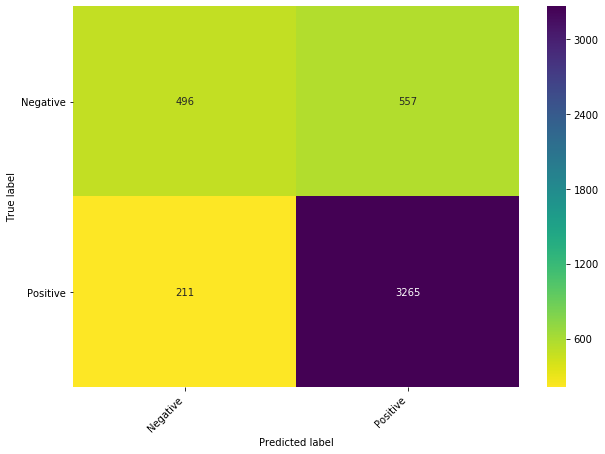

In [57]:
conf_mat = confusion_matrix(y_true=y_val, y_pred=results['predictions'])
cm = print_confusion_matrix(conf_mat, ['Negative', 'Positive'],cmap = 'viridis_r')
plt.savefig('output\with_all_fea.png')

For this project we will maximize accuracy because we want to identify negative and positive comments respectively


In [28]:
def plot_ROC(y_true,y_proba,AUC,figsize = (7,5),color = 'darkturquoise',title='ROC Curve'):
    '''Helper function to plot ROC graph'''
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
    #set size
    plt.figure(figsize=figsize)
    #plot
    plt.plot(fpr, tpr,lw=2,c=color,label = f"AUC: {AUC:.2f}")
    #adjustments
    plt.plot([0,1],[0,1],c='grey',ls='--')
    plt.legend()
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title(title);

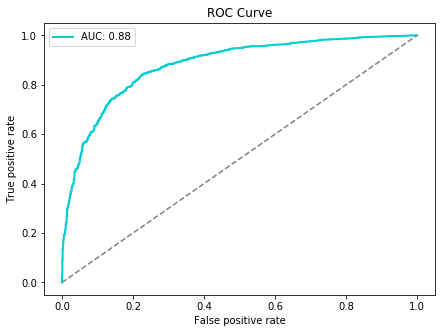

In [22]:
plot_ROC(y_val,results['predict_proba'],results['AUC'])
plt.savefig("ROC_curve_1st_model_w_all_features.png")

Now let's try to fit the model using just the text component and throw away all the other features

In [58]:
model = LogisticRegression()

In [59]:
fitted_model,results = model_fit_train_score(model,X_train_vectorized, y_train,X_val_vectorized,y_val)

C:\Users\Zhiqing\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [60]:
print(f"Accuracy: {results['Accuracy']:.3f} \nF1 score: {results['F1']:.3f} \nAUC score: {results['AUC']:.3f}")

Accuracy: 0.869 
F1 score: 0.916 
AUC score: 0.912


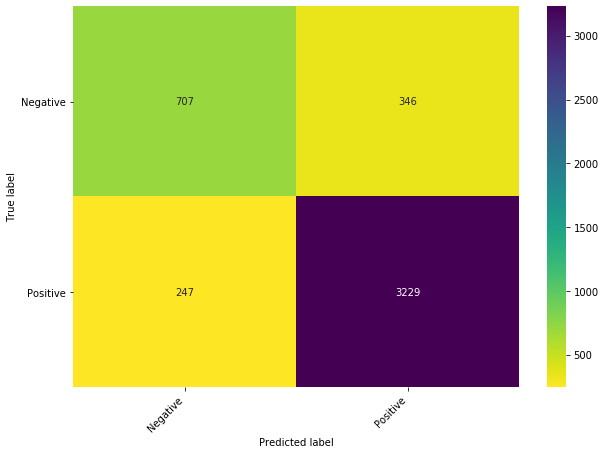

In [63]:
conf_mat = confusion_matrix(y_true=y_val, y_pred=results['predictions'])
cm = print_confusion_matrix(conf_mat, ['Negative', 'Positive'],cmap = 'viridis_r')
plt.savefig('output/text_only_conf.png')

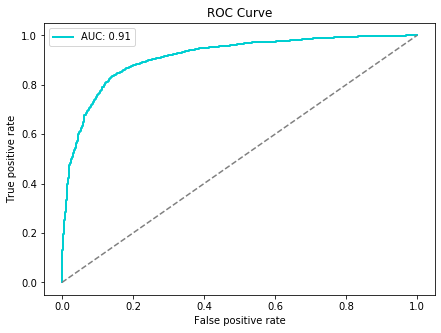

In [27]:
plot_ROC(y_val,results['predict_proba'],results['AUC'])

In [32]:
type(vect.get_feature_names())

list

In [33]:
#try to see the 
feature_names = np.array(vect.get_feature_names())

# Sort the coefficients from the model
sorted_coef_index = model.coef_[0].argsort()

# Find the 10 smallest and 10 largest coefficients
# The 10 largest coefficients are being indexed using [:-11:-1] 
# so the list returned is in order of largest to smallest
print('Smallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))

Smallest Coefs:
['poor' 'within' 'awful' 'unflattering' 'drab' 'start' 'cheap' 'bad'
 'disappointed' 'completely']

Largest Coefs: 
['highly' 'compliments' 'pleased' 'sexy' 'breast' 'hesitant' 'helps'
 'gigantic' 'paired' 'stylish']


It is quite a surprising finding, it shows that when we only fit the logistic regression model with the review textx only, the model performance improves by reading AUC score..

Let's see if we need to keep the other features other than review by looking at the feature importance/ ranking from logistic model and random forest

In [81]:
model = LogisticRegression()
fitted_model,results = model_fit_train_score(model,X_train_add, y_train,X_val_add,y_val)

In [82]:
print(f"Accuracy: {results['Accuracy']:.3f} \nF1 score: {results['F1']:.3f} \nAUC score: {results['AUC']:.3f}")

Accuracy: 0.767 
F1 score: 0.868 
AUC score: 0.561


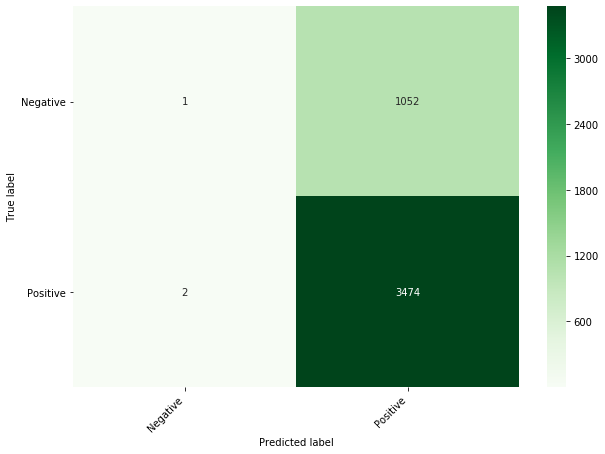

In [83]:
conf_mat = confusion_matrix(y_true=y_val, y_pred=results['predictions'])
cm = print_confusion_matrix(conf_mat, ['Negative', 'Positive'])

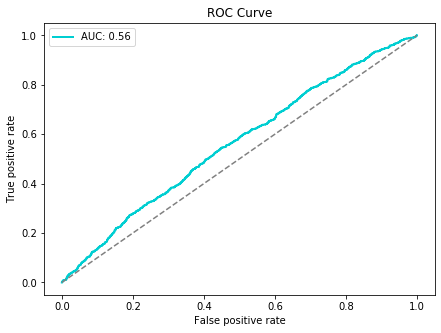

In [84]:
plot_ROC(y_val,results['predict_proba'],results['AUC'])

This model performs slightly better than a random guess.. Let's see what is the most importance feature

In [85]:
fitted_model.coef_

array([[ 0.00080608,  0.00991823, -0.00059365, -0.01683983,  0.29137688,
        -0.00956062,  0.03067579,  0.31652341, -0.10889516,  0.12248189,
        -0.06278421,  0.07074864, -0.03819385,  0.01261134,  0.02916623,
        -0.10889516, -0.01853184, -0.04028818,  0.003896  ,  0.01227683,
         0.10796285, -0.0631013 , -0.02103325,  0.03670926,  0.0663256 ,
         0.0584718 ,  0.03974682, -0.03819385,  0.10112685,  0.04255263,
         0.05909376,  0.04193453,  0.00182638,  0.00144609]])

In [87]:
feature_names = np.array(data_train_features_only_dummied.columns)

# Sort the coefficients from the model
sorted_coef_index = model.coef_[0].argsort()

# Find the 10 smallest and 10 largest coefficients
# The 10 largest coefficients are being indexed using [:-11:-1] 
# so the list returned is in order of largest to smallest
print('Smallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))

Smallest Coefs:
['Department_Dresses' 'Class_Dresses' 'Class_Sweaters' 'Department_Tops'
 'Class_Blouses' 'Class_Trend' 'Department_Trend' 'Class_Skirts'
 'Class_Pants' 'Positive_fb_count']

Largest Coefs: 
['Department_Intimate' 'Division_Initmates' 'Department_Bottoms'
 'Class_Lounge' 'Class_Jeans' 'Department_Jackets' 'Class_Sleep'
 'Class_Shorts' 'Class_Jackets' 'Class_Legwear']


In [88]:
len(feature_names)

34

In [90]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()

In [91]:
fitted_model,results = model_fit_train_score(model,X_train_add, y_train,X_val_add,y_val)

In [92]:
print(f"Accuracy: {results['Accuracy']:.3f} \nF1 score: {results['F1']:.3f} \nAUC score: {results['AUC']:.3f}")

Accuracy: 0.741 
F1 score: 0.847 
AUC score: 0.566


In [94]:
sorted_impt_index = fitted_model.feature_importances_.argsort()

In [99]:
print('Most important features: \n{}'.format(feature_names[sorted_impt_index[:-10:-1]]))

Most important features: 
['review_len' 'Age' 'clothing_ID' 'Positive_fb_count' 'Division_General'
 'Division_General Petite' 'Class_Knits' 'Class_Blouses' 'Class_Sweaters']


Let's try to add the features one by one to the review text

Starting with the most importance found in random forest model

In [115]:
# transform the documents in the training data to a document-term matrix
X_train_to_add = data_train_features_only_dummied.loc[list(X_train.index),'review_len'].to_numpy().reshape((13584,1))
X_train_vect_stack_1 = np.hstack((X_train_vectorized,X_train_to_add))

In [113]:
X_val_to_add = data_train_features_only_dummied.loc[list(X_val.index),"review_len"].to_numpy().reshape((4529,1))
X_val_vect_stack_1 = np.hstack((X_val_vectorized,X_val_to_add))

In [117]:
model = LogisticRegression()
fitted_model,results = model_fit_train_score(model,X_train_vect_stack_1, y_train,X_val_vect_stack_1,y_val)

C:\Users\Zhiqing\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [118]:
print(f"Accuracy: {results['Accuracy']:.3f} \nF1 score: {results['F1']:.3f} \nAUC score: {results['AUC']:.3f}")

Accuracy: 0.854 
F1 score: 0.909 
AUC score: 0.897


The model still performs worse than the text alone;

We will focus on using only the text for sentiment reviews

What about recommendation?

In [125]:
y2_train = data_train.loc[list(y_train.index),"Reco"]
y2_val = data_train.loc[list(y_val.index),"Reco"]

In [126]:
model = LogisticRegression()
fitted_model,results = model_fit_train_score(model,X_train_vectorized, y2_train,X_val_vectorized,y2_val)

C:\Users\Zhiqing\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [127]:
print(f"Accuracy: {results['Accuracy']:.3f} \nF1 score: {results['F1']:.3f} \nAUC score: {results['AUC']:.3f}")

Accuracy: 0.887 
F1 score: 0.932 
AUC score: 0.915


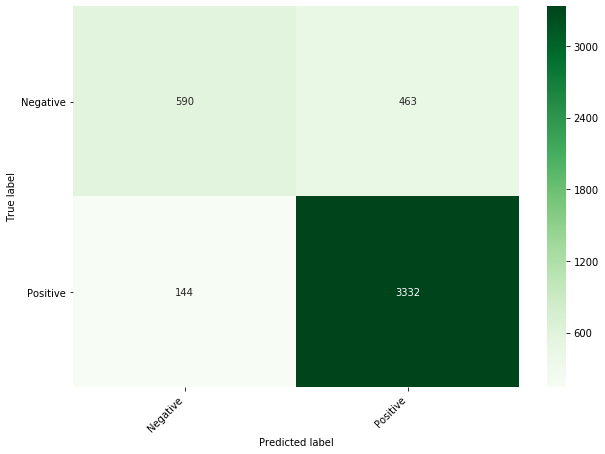

In [128]:
conf_mat = confusion_matrix(y_true=y_val, y_pred=results['predictions'])
cm = print_confusion_matrix(conf_mat, ['Negative', 'Positive'])

Recommendation is quite similar to the rating, let's focus our effort on maximizing performance for rating for now.. and we will check the reco once we have time

In [37]:
model = LogisticRegressionCV(Cs = [0.1,0.5,1,5,10],cv = 5,penalty =  'l2',max_iter = 500,random_state = seed,
         multi_class = 'ovr')

In [38]:
fitted_model,results = model_fit_train_score(model,X_train_vectorized, y_train,X_val_vectorized,y_val)

/Users/zhengzhiqing/opt/anaconda3/envs/metisnow/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/zhengzhiqing/opt/anaconda3/envs/metisnow/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    http

In [39]:
fitted_model

LogisticRegressionCV(Cs=[0.1, 0.5, 1, 5, 10], class_weight=None, cv=5,
                     dual=False, fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=None, max_iter=500, multi_class='ovr',
                     n_jobs=None, penalty='l2', random_state=123, refit=True,
                     scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [40]:
fitted_model.C_

array([0.1])

In [41]:
print(f"Accuracy: {results['Accuracy']:.3f} \nF1 score: {results['F1']:.3f} \nAUC score: {results['AUC']:.3f}")

Accuracy: 0.877 
F1 score: 0.922 
AUC score: 0.922


In [42]:
#try to see the 
feature_names = np.array(vect.get_feature_names())

# Sort the coefficients from the model
sorted_coef_index = model.coef_[0].argsort()

# Find the 10 smallest and 10 largest coefficients
# The 10 largest coefficients are being indexed using [:-11:-1] 
# so the list returned is in order of largest to smallest
print('Smallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))

Smallest Coefs:
['disappointed' 'unflattering' 'returning' 'cheap' 'bad' 'returned'
 'wanted' 'disappointing' 'completely' 'huge']

Largest Coefs: 
['compliments' 'perfect' 'comfortable' 'highly' 'glad' 'perfectly'
 'amazing' 'love' 'happy' 'comfy']


In [23]:
model = LogisticRegressionCV(Cs = [0.1,0.15,0.2,0.3],cv = 5,penalty =  'l2',max_iter = 500,random_state = seed,
         multi_class = 'ovr')
fitted_model,results = model_fit_train_score(model,X_train_vectorized, y_train,X_val_vectorized,y_val)

In [24]:
fitted_model.C_

array([0.15])

In [25]:
print(f"Accuracy: {results['Accuracy']:.3f} \nF1 score: {results['F1']:.3f} \nAUC score: {results['AUC']:.3f}")

Accuracy: 0.875 
F1 score: 0.921 
AUC score: 0.922


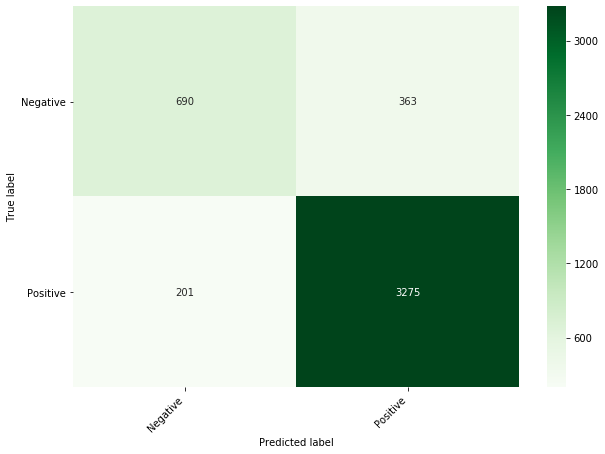

In [26]:
conf_mat = confusion_matrix(y_true=y_val, y_pred=results['predictions'])
cm = print_confusion_matrix(conf_mat, ['Negative', 'Positive'])

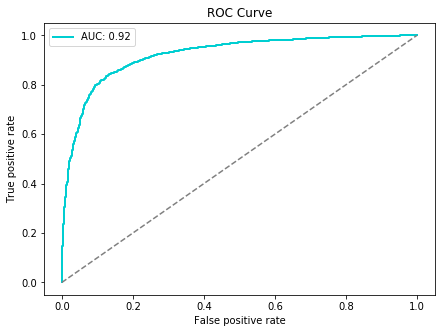

In [29]:
plot_ROC(y_val,results['predict_proba'],results['AUC'])
plt.savefig("ROC_curve_1st_model_wopt_c.png")

In [31]:
#try to see the most relavent features
feature_names = np.array(vect.get_feature_names())

# Sort the coefficients from the model
sorted_coef_index = model.coef_[0].argsort()

# Find the 10 smallest and 10 largest coefficients
# The 10 largest coefficients are being indexed using [:-11:-1] 
# so the list returned is in order of largest to smallest
print('Smallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))

Smallest Coefs:
['unflattering' 'disappointed' 'cheap' 'bad' 'returning' 'returned'
 'disappointing' 'completely' 'wanted' 'poor']

Largest Coefs: 
['compliments' 'perfect' 'comfortable' 'highly' 'amazing' 'glad' 'happy'
 'feminine' 'sold' 'perfectly']


We found our optimized parameter C for a model that is built by countvectorizer without stop word removal nor lemmatization

Now we want to check if stopwords removal will help to improve the model

In [64]:
import spacy
import en_core_web_sm

In [65]:
nlp = en_core_web_sm.load()
stopwords = list(spacy.lang.en.stop_words.STOP_WORDS)

In [66]:
vect_stop_words_rm = CountVectorizer(stop_words=stopwords).fit(X_train)
X_train_vectorized_rm = vect_stop_words_rm.transform(X_train)
X_val_vectorized_rm = vect_stop_words_rm.transform(X_val)

C:\Users\Zhiqing\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [67]:
model = LogisticRegressionCV(Cs = [0.1,0.15,0.2,0.3],cv = 5,penalty =  'l2',max_iter = 500,random_state = seed,
         multi_class = 'ovr')
fitted_model,results = model_fit_train_score(model,X_train_vectorized_rm, y_train,X_val_vectorized_rm,y_val)

In [68]:
fitted_model.C_

array([0.3])

In [69]:
print(f"Accuracy: {results['Accuracy']:.3f} \nF1 score: {results['F1']:.3f} \nAUC score: {results['AUC']:.3f}")

Accuracy: 0.866 
F1 score: 0.915 
AUC score: 0.907


In [52]:
feature_names = np.array(vect_stop_words_rm.get_feature_names())

# Sort the coefficients from the model
sorted_coef_index = fitted_model.coef_[0].argsort()

# Find the 10 smallest and 10 largest coefficients
# The 10 largest coefficients are being indexed using [:-11:-1] 
# so the list returned is in order of largest to smallest
print('Smallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))

Smallest Coefs:
['unflattering' 'disappointed' 'bad' 'poor' 'disappointing' 'cheap'
 'returned' 'awful' 'completely' 'wanted']

Largest Coefs: 
['compliments' 'highly' 'perfect' 'glad' 'pleased' 'stylish' 'elegant'
 'paired' 'comfortable' 'works']


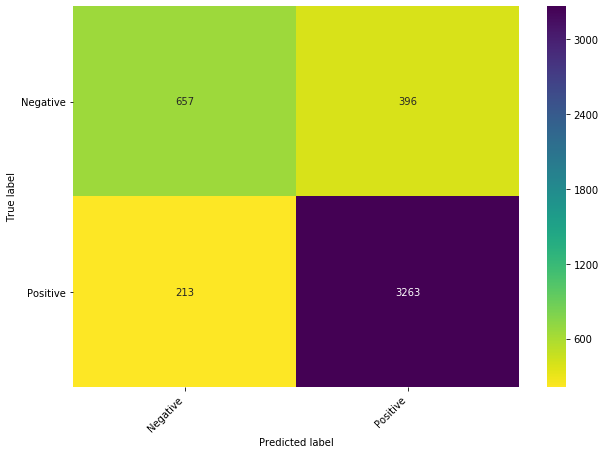

In [72]:
conf_mat = confusion_matrix(y_true=y_val, y_pred=results['predictions'])
cm = print_confusion_matrix(conf_mat, ['Negative', 'Positive'],cmap = 'viridis_r')
plt.savefig('output/remove_stpw.png')

Interestingly, removing stop words makes the model performs worse; maybe the list of stopwords is not suitable for this data?
We can always explore more here

Next we would like to explore if lemmatization could improve the model. We will use the lemmatizer provided by SpaCy

In [73]:
def lemma_and_stop (text):
    docs = nlp.pipe(text)
    lemma = []
    lemma_and_stop = []

    for doc in docs:
        if doc.is_parsed:
            lemma.append(" ".join([n.lemma_ for n in doc]))
            lemma_and_stop.append(" ".join([n.lemma_ for n in doc if n.is_stop == False]))
        else:
            # We want to make sure that the lists of parsed results have the
            # same number of entries of the original Dataframe, so add some blanks in case the parse fails
            lemma.append(None)
            lemma_and_stop.append(None)
    return lemma,lemma_and_stop

In [74]:
lemma_X_train,lem_and_stop_X_train = lemma_and_stop(X_train)

In [75]:
lemma_X_train[:1]

['this be really cute but do run large   if -PRON- in between size size down   the fabric at the front be super bulky but with a small size could be ok   -PRON- be so itchy   imo uncomfotably so   i would have return for a small size have -PRON- not be so uncomfortable   ugh why   i love the sleeve   very cute bell   and the back hung nicely   -PRON- need to make this in a cotton   vocoder and no wool   love bit could not bear -PRON-']

In [76]:
lemma_X_val,lem_and_stop_X_val = lemma_and_stop(X_val)

In [77]:
vectorizer = CountVectorizer().fit(lemma_X_train)
X_train_vectorized_lm = vectorizer.transform(lemma_X_train)
X_val_vectorized_lm = vectorizer.transform(lemma_X_val)

In [78]:
model = LogisticRegressionCV(Cs = [0.1,0.15,0.2,0.3],cv = 5,penalty =  'l2',max_iter = 500,random_state = seed,
         multi_class = 'ovr')
fitted_model,results = model_fit_train_score(model,X_train_vectorized_lm, y_train,X_val_vectorized_lm,y_val)

In [72]:
fitted_model.C_

array([0.3])

In [79]:
print(f"Accuracy: {results['Accuracy']:.3f} \nF1 score: {results['F1']:.3f} \nAUC score: {results['AUC']:.3f}")

Accuracy: 0.870 
F1 score: 0.917 
AUC score: 0.916


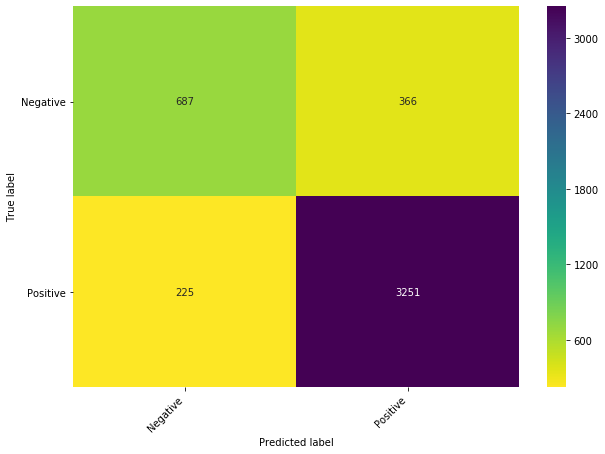

In [80]:
conf_mat = confusion_matrix(y_true=y_val, y_pred=results['predictions'])
cm = print_confusion_matrix(conf_mat, ['Negative', 'Positive'],cmap = 'viridis_r')
plt.savefig('output/lemmatized_only.png')

I realize that comparing stopwords and lemmatization v.s. original model this way has some flaw: i.e. the model is tested on only one validation set.. I will adapat the model_fit_train_score to reflect our latest use case

(in fact all the comparison before is flawed)

In [12]:
from sklearn.model_selection import StratifiedKFold
from collections import defaultdict

def model_fit_train_score_skf (model,X,y,kfold = 5):
    '''This function takes in three arguments:model (model object), X,y
    It will be splitted by stratified k fold algo
    The data will be fitted using the model passed in by the user
    It returns the fitted model object and lists of Accuracy score as well as F1 score and AUC (area under curve)'''
    skf = StratifiedKFold(n_splits=kfold)
    results_dict = defaultdict()
    predict = []
    predict_prob = []
    Accuracy = []
    F1 = []
    AUC = []
    
    for train_index, test_index in skf.split(X, y):
        #get current split
        x_train, x_val = X[train_index], X[test_index]
        y_train, y_val = y[train_index], y[test_index]
        #fit model with latest train set
        model.fit(x_train,y_train)
        #calculate predictions
        y_pred = model.predict(x_val)
        predictions = model.predict_proba(x_val)
        predict.append(y_pred)
        predict_prob.append(predictions[:,1])
        Accuracy.append(accuracy_score(y_true=y_val, y_pred=y_pred))
        F1.append(f1_score(y_true=y_val, y_pred=y_pred))
        AUC.append(roc_auc_score(y_val, predictions[:,1]))
    
    results_dict['predictions'] = predict
    results_dict['predict_proba'] = predict_prob
    results_dict['Accuracy_mean'] = np.mean(Accuracy)
    results_dict['F1_mean'] = np.mean(F1)
    results_dict['AUC_mean'] = np.mean(AUC)
    results_dict['Accuracy_std'] = np.std(Accuracy)
    results_dict['F1_std'] = np.std(F1)
    results_dict['AUC_std'] = np.std(AUC)
    
    return model,results_dict

Model with little pre-processing

In [3]:
vect = CountVectorizer().fit(data_train.RAW_Text)

In [4]:
X_vect = vect.transform(data_train.RAW_Text)

In [74]:
model = LogisticRegressionCV(Cs = [0.1,0.15,0.2,0.3],cv = 5,penalty =  'l2',max_iter = 200,random_state = seed,
         multi_class = 'ovr')
fitted_model,results = model_fit_train_score_skf(model,X_vect,np.array(data_train.Positively_rated))

In [75]:
print(f"Accuracy: {results['Accuracy_mean']:.3f} \nF1 score: {results['F1_mean']:.3f} \nAUC score: {results['AUC_mean']:.3f}")

Accuracy: 0.878 
F1 score: 0.923 
AUC score: 0.923


In [ ]:
fitted_model.C_

Model with just lemmatization

In [79]:
lemma_X,lem_and_stop_X = lemma_and_stop(data_train.RAW_Text)

In [80]:
vectorizer = CountVectorizer().fit(lemma_X)
X_lemma_vect = vectorizer.transform(lemma_X)

In [81]:
model = LogisticRegressionCV(Cs = [0.1,0.15,0.2,0.3],cv = 5,penalty =  'l2',max_iter = 200,random_state = seed,
         multi_class = 'ovr')
fitted_model,results = model_fit_train_score_skf(model,X_lemma_vect,np.array(data_train.Positively_rated))

C:\Users\Zhiqing\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Zhiqing\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic

In [82]:
fitted_model.C_

array([0.15])

In [83]:
print(f"Accuracy: {results['Accuracy_mean']:.3f} \nF1 score: {results['F1_mean']:.3f} \nAUC score: {results['AUC_mean']:.3f}")

Accuracy: 0.875 
F1 score: 0.921 
AUC score: 0.917


Model with stopwords only

In [107]:
vect_stop_words_rm = CountVectorizer(stop_words=stopwords).fit(data_train.Text)
X_vectorized_rm = vect_stop_words_rm.transform(data_train.Text)

C:\Users\Zhiqing\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [109]:
model = LogisticRegressionCV(Cs = [0.1,0.15,0.2,0.3],cv = 5,penalty =  'l2',max_iter = 500,random_state = seed,
         multi_class = 'ovr')
fitted_model,results = model_fit_train_score_skf(model,X_vectorized_rm, np.array(data_train.Positively_rated))

In [111]:
print(f"Accuracy: {results['Accuracy_mean']:.3f} \nF1 score: {results['F1_mean']:.3f} \nAUC score: {results['AUC_mean']:.3f}")

Accuracy: 0.870 
F1 score: 0.918 
AUC score: 0.913


Note: removing stopword or lemmatization would slightly decrease the performance of the model. We will not remove neither one for the BOW model

Next, try MNB and SVC to see if it improves the performance

In [23]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
clf = MultinomialNB()

In [29]:
parameters_MNB = {'alpha':[0.5,1,5,10]       }
clf_grid = GridSearchCV(estimator = clf, param_grid = parameters_MNB, verbose=1,n_jobs = -1,
                        scoring='f1',cv = 5,refit='AUC',
                        return_train_score=True).fit(X_vect, np.array(data_train.Positively_rated))

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.1s finished


In [30]:
clf_grid.best_estimator_

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

In [25]:
best_clf = eval(str(clf_grid.best_estimator_))

In [26]:
fitted_model,results = model_fit_train_score_skf(best_clf,X_vect, y)

In [27]:
print(f"Accuracy: {results['Accuracy_mean']:.3f} \nF1 score: {results['F1_mean']:.3f} \nAUC score: {results['AUC_mean']:.3f}")

Accuracy: 0.876 
F1 score: 0.920 
AUC score: 0.920


In [36]:
from sklearn.svm import LinearSVC
from sklearn.metrics import make_scorer


In [38]:
scoring = {'AUC': 'roc_auc'}

In [52]:
clf = LinearSVC()
parameters_SVC = {'C':[0.00001,0.0001,0.001,0.005,0.01,0.05], 'penalty':['l1','l2','elasticnet'],'loss':['hinge','squared_hinge'] 
                }
clf_grid = GridSearchCV(estimator = clf, param_grid = parameters_SVC, verbose=1,n_jobs = -1,
                        scoring='f1',cv = 5,refit='AUC',
                        return_train_score=True).fit(X_vect, np.array(data_train.Positively_rated))

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    0.5s finished


In [58]:
clf_grid.cv_results_

{'mean_fit_time': array([0.00359039, 0.0058866 , 0.00309348, 0.00339141, 0.00977292,
        0.00738034, 0.00678148, 0.00518575, 0.00379   , 0.00299163,
        0.0176549 , 0.00298958, 0.00289483, 0.0165554 , 0.00518551,
        0.00299201, 0.0127656 , 0.00817766, 0.00398932, 0.0103724 ,
        0.00339074, 0.00299201, 0.00797839, 0.00638266, 0.00319133,
        0.01555862, 0.00339026, 0.00279226, 0.01017175, 0.00378942,
        0.00299129, 0.01376281, 0.00518622, 0.00339108, 0.01156836,
        0.00279236]),
 'std_fit_time': array([7.98130349e-04, 4.91503388e-04, 2.06846276e-04, 7.98630933e-04,
        3.24083107e-03, 8.28696253e-03, 6.59739378e-03, 3.99041471e-04,
        1.16300654e-03, 6.81059687e-07, 7.87899246e-03, 6.30242644e-04,
        4.91249119e-04, 1.32548191e-02, 4.38778401e-03, 1.11420836e-06,
        8.25844566e-03, 5.54959513e-03, 3.02562019e-03, 4.88228395e-04,
        7.97892536e-04, 9.72560790e-07, 1.09284125e-03, 5.41128314e-03,
        3.99184522e-04, 9.19758724e-0

In [54]:
clf_grid.best_estimator_

LinearSVC(C=1e-05, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
          penalty='l2', random_state=None, tol=0.0001, verbose=0)

In [56]:
clf_grid.best_score_

0.8716750733217493

In [59]:
#best estimator returned by grid search
best_SVC = SVC(C=0.00001, probability=True, kernel='linear')

In [61]:
fitted_model,results = model_fit_train_score_skf(best_SVC,X_vect, np.array(data_train.Positively_rated))

In [62]:
print(f"Accuracy: {results['Accuracy_mean']:.3f} \nF1 score: {results['F1_mean']:.3f} \nAUC score: {results['AUC_mean']:.3f}")

Accuracy: 0.773 
F1 score: 0.872 
AUC score: 0.500


defaultdict(None,
            {'predictions': [array([1, 1, 1, ..., 1, 1, 1], dtype=int64),
              array([1, 1, 1, ..., 1, 1, 1], dtype=int64),
              array([1, 1, 1, ..., 1, 1, 1], dtype=int64),
              array([1, 1, 1, ..., 1, 1, 1], dtype=int64),
              array([1, 1, 1, ..., 1, 1, 1], dtype=int64)],
             'predict_proba': [array([0.77254239, 0.77254239, 0.77254239, ..., 0.77254239, 0.77254239,
                     0.77254239]),
              array([0.77256698, 0.77256698, 0.77256698, ..., 0.77256698, 0.77256698,
                     0.77256698]),
              array([0.7726493, 0.7726493, 0.7726493, ..., 0.7726493, 0.7726493,
                     0.7726493]),
              array([0.77256079, 0.77256079, 0.77256079, ..., 0.77256079, 0.77256079,
                     0.77256079]),
              array([0.77256079, 0.77256079, 0.77256079, ..., 0.77256079, 0.77256079,
                     0.77256079])],
             'Accuracy_mean': 0.7725390561833235,
    

Now we would like to apply LSA on BOW model and see if it can improve performance

In [5]:
from sklearn.decomposition import TruncatedSVD

In [16]:
SVD = TruncatedSVD(n_components=300, algorithm='randomized', n_iter=5, random_state=seed, tol=0.0)

In [17]:
X_vect_SVD = SVD.fit_transform(X_vect)

In [20]:
y = np.array(data_train.Positively_rated)
model = LogisticRegressionCV(Cs = [0.1,0.15,0.2,0.3,1,5],cv = 5,penalty =  'l2',max_iter = 500,random_state = seed,
         multi_class = 'ovr')
fitted_model,results = model_fit_train_score_skf(model,X_vect_SVD, y)

In [21]:
print(f"Accuracy: {results['Accuracy_mean']:.3f} \nF1 score: {results['F1_mean']:.3f} \nAUC score: {results['AUC_mean']:.3f}")

Accuracy: 0.864 
F1 score: 0.914 
AUC score: 0.905


Now we would like to add random forest classifier in the game

In [31]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()

In [ ]:
'''parameters_rf = {'n_estimators':[100]}
clf_grid = GridSearchCV(estimator = clf, param_grid = parameters_rf, verbose=1,n_jobs = -1,
                        scoring='f1',cv = 5,refit='AUC',
                        return_train_score=True).fit(X_vect, np.array(data_train.Positively_rated))'''

In [32]:
fitted_model,results = model_fit_train_score_skf(clf,X_vect, y)

In [33]:
print(f"Accuracy: {results['Accuracy_mean']:.3f} \nF1 score: {results['F1_mean']:.3f} \nAUC score: {results['AUC_mean']:.3f}")

Accuracy: 0.820 
F1 score: 0.895 
AUC score: 0.912
